In [1]:
# !pipreqs --force
!pip install -r requirements.txt
!pip install tensorflow-gpu
#
# !pip install tensorflow yfinance pandas sklearn
# import tensorflow as tf
# !pip install yfinance


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
import pandas as pd
import tensorflow as tf
import yfinance as yf


In [3]:
print("Hello")
tf.__version__
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# !pip freeze > requirements.txt



Hello
Num GPUs Available:  0


In [4]:
# !pip freeze > requirements.txt
from datetime import datetime, timedelta
end_date = datetime.today().strftime('%Y-%m-%d')
start_date_dt = datetime.now() - timedelta(days=10*365)
print(start_date_dt)
start_date = start_date_dt.strftime('%Y-%m-%d')
print(start_date)
print(end_date)
# aapl = yf.download("AAPL")
fb = yf.download("FB", start = start_date, end = end_date)
# aapl_history = aapl.history(period="max")

2012-05-17 09:21:40.620374
2012-05-17
2022-05-15
[*********************100%***********************]  1 of 1 completed


In [5]:
type(fb)
df = pd.DataFrame(fb)
df
df1 = df.reset_index()['Close']
df1

0        38.230000
1        34.029999
2        31.000000
3        32.000000
4        33.029999
           ...    
2509    196.210007
2510    197.649994
2511    188.740005
2512    191.240005
2513    198.619995
Name: Close, Length: 2514, dtype: float64

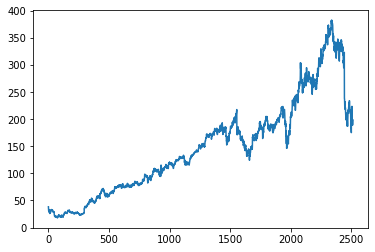

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [8]:
# Split data
train_size = int(len(df1)*.95) # 65%
test_size = len(df1) - train_size
train, test = df1[0:train_size,:], df1[train_size:len(df1), :1]

In [9]:
print(train_size)
print(test_size)

2388
126


In [10]:
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [12]:
print(X_train.shape), print(y_train.shape)

(2287, 100)
(2287,)


(None, None)

In [13]:
print(X_test.shape), print(y_test.shape)

(25, 100)
(25,)


(None, None)

In [14]:
# Reshape to be inputted into LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(2287, 100, 1)
(25, 100, 1)


In [15]:
# Create Stacked LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(Dropout(.5))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-traina

In [17]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=250, verbose=1)

Epoch 1/100
10/10 [==============================] - 10s 477ms/step - loss: 0.0676 - val_loss: 0.0016
Epoch 2/100
10/10 [==============================] - 4s 352ms/step - loss: 0.0122 - val_loss: 0.0109
Epoch 3/100
10/10 [==============================] - 4s 384ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 4/100
10/10 [==============================] - 4s 397ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 5/100
10/10 [==============================] - 4s 377ms/step - loss: 0.0015 - val_loss: 0.0071
Epoch 6/100
10/10 [==============================] - 4s 379ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 7/100
10/10 [==============================] - 4s 379ms/step - loss: 9.9377e-04 - val_loss: 0.0027
Epoch 8/100
10/10 [==============================] - 4s 388ms/step - loss: 9.9832e-04 - val_loss: 0.0036
Epoch 9/100
10/10 [==============================] - 4s 385ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 10/100
10/10 [==============================] - 4s 398ms/step - loss: 9.7258

In [18]:
# import tensorflow as tf


In [19]:
# import tensorflow as tf
tf.__version__

'2.8.0'

In [20]:
prediction = model.predict(X_train)
test_prediction = model.predict(X_test)
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 1), dtype=tf.float32, name='lstm_input'), name='lstm_input', description="created by layer 'lstm_input'")


In [21]:
prediction = scaler.inverse_transform(prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [22]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, prediction))

164.87292780522873

In [23]:
math.sqrt(mean_squared_error(y_test, test_prediction))

207.7004184065029

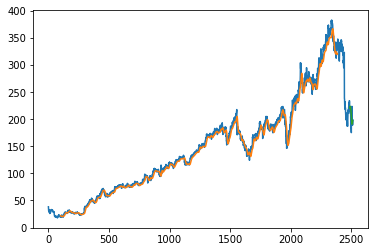

In [24]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(prediction)+look_back, :] = prediction
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(prediction)+(look_back*2)+1:len(df1)-1, :] = test_prediction
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [25]:
len(test)

126

In [26]:
x_input = test[len(test)-100:].reshape(1, -1)
x_input.shape

(1, 100)

In [27]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [28]:
# temp_input

In [29]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


# print(lst_output)

1 day input [0.85806014 0.87120317 0.90122102 0.90133079 0.89233093 0.89622717
 0.8742489  0.88025796 0.87474278 0.8408287  0.86357524 0.8617369
 0.85152974 0.86881603 0.86577038 0.84716701 0.86203869 0.82431061
 0.82826177 0.81994788 0.78320763 0.79840855 0.77492111 0.75977503
 0.7598025  0.77920153 0.81089317 0.8266429  0.83761835 0.60373165
 0.60189327 0.56847306 0.55549457 0.58792703 0.57714367 0.55376597
 0.54868981 0.55774456 0.54550692 0.52127867 0.51702568 0.50583072
 0.49587049 0.52097684 0.52887913 0.53038826 0.50969957 0.5223762
 0.50827275 0.50028811 0.46574291 0.47348058 0.49600769 0.48698041
 0.46612705 0.46343808 0.47825491 0.51008371 0.52163534 0.54536976
 0.53165046 0.54580875 0.53705587 0.55382086 0.55999454 0.56485115
 0.58205517 0.57654002 0.56147621 0.56830844 0.59311292 0.587488
 0.56405545 0.56309508 0.5613939  0.54528745 0.53892167 0.54125397
 0.52805597 0.52967488 0.54761971 0.5012759  0.46738925 0.45652354
 0.46442587 0.44785293 0.43138977 0.51584579 0.5014131

In [30]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [31]:
len(df1)
print(scaler.inverse_transform(df1[-1:]))
print(scaler.inverse_transform(lst_output[0:]))

[[198.61999512]]
[[198.68182708]
 [198.81480388]
 [198.64108575]
 [198.2643127 ]
 [197.77326627]
 [197.23432081]
 [196.69128058]
 [196.16850784]
 [195.67603855]
 [195.21428546]
 [194.7786216 ]
 [194.36223681]
 [193.95842959]
 [193.56153026]
 [193.16744405]
 [192.77371626]
 [192.37915214]
 [191.9833824 ]
 [191.58680891]
 [191.18985527]
 [190.79328178]
 [190.3975229 ]
 [190.00316515]
 [189.61043662]
 [189.2194242 ]
 [188.83024736]
 [188.4428518 ]
 [188.05713977]
 [187.67300265]
 [187.29034269]]


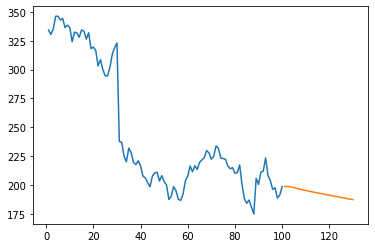

In [32]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

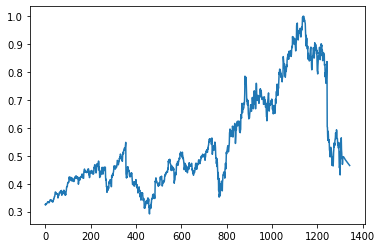

In [33]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [34]:
df3=scaler.inverse_transform(df3).tolist()


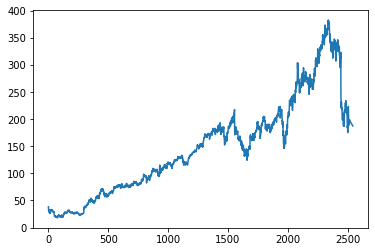

In [35]:
plt.plot(df3)


In [36]:
import pickle

# filename = 'model.sav'
# pickle.dump(model, open(filename, 'wb'))
# tf.keras.models.save_model(model, "filename.pkl")
# import time
# #save model
# ts = int(time.time())
# file_path = f"tf-models/lstm/{ts}/"
# model.save(filepath=file_path, save_format='tf')

In [37]:
# import tarfile
# import os

# def tar_folder(output_filename: str, source_dir: str):
#     with tarfile.open(output_filename, "w:gz") as tar:
#         tar.add(source_dir, arcname=os.path.basename(source_dir))

# OUT_FILE = 'tf-models-lstm.tar.gz'

# SOURCE_FILE = "tf-models"

# tar_folder(output_filename=OUT_FILE, source_dir=SOURCE_FILE)
# print(OUT_FILE)

In [38]:
# import sagemaker

# sagemaker_session = sagemaker.Session(default_bucket='stocks-models')
# upload_data = sagemaker_session.upload_data(path='tf-models-lstm.tar.gz', key_prefix='my_prefix')

# print('upload_data : {}'.format(upload_data))

In [39]:
# print(prediction[:50])
import time
from datetime import datetime

SECONDS_IN_DAY = 86400

now = int( time.time() )
print( now )
print(datetime.fromtimestamp(now))

print("NEXT DAY\n")
print(now + SECONDS_IN_DAY)
print(datetime.fromtimestamp(now + SECONDS_IN_DAY))

data_set = {"c": [], "t": []}
inversed_output = scaler.inverse_transform(lst_output)
inversed_output.tolist()
for i in range(len(inversed_output)):
    now = SECONDS_IN_DAY + now
    data_set["c"].insert(i, round(float(inversed_output[i]), 2))
    data_set["t"].insert(i, int(now))


print(data_set.get("c")[-1])
print(data_set.get("t")[-1])
print(datetime.fromtimestamp(data_set.get("t")[3]))
print(data_set)



# print(inversed_output)

1652624910
2022-05-15 09:28:30
NEXT DAY

1652711310
2022-05-16 09:28:30
187.29
1655216910
2022-05-19 09:28:30
{'c': [198.68, 198.81, 198.64, 198.26, 197.77, 197.23, 196.69, 196.17, 195.68, 195.21, 194.78, 194.36, 193.96, 193.56, 193.17, 192.77, 192.38, 191.98, 191.59, 191.19, 190.79, 190.4, 190.0, 189.61, 189.22, 188.83, 188.44, 188.06, 187.67, 187.29], 't': [1652711310, 1652797710, 1652884110, 1652970510, 1653056910, 1653143310, 1653229710, 1653316110, 1653402510, 1653488910, 1653575310, 1653661710, 1653748110, 1653834510, 1653920910, 1654007310, 1654093710, 1654180110, 1654266510, 1654352910, 1654439310, 1654525710, 1654612110, 1654698510, 1654784910, 1654871310, 1654957710, 1655044110, 1655130510, 1655216910]}


In [40]:
import json
with open('../src/stock_json/fb.json', 'w', encoding='utf-8') as f:
    json.dump(data_set, f, ensure_ascii=False, indent=4)